# Homework 1 - ORF finding: how many genes are in the SARS-Cov-2 genome?

Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) is a strain of coronavirus that causes COVID-19. Throughout these homework assignments, we will analyze this virus and try to understand its origins and inner workings. We will implement the necessary bioinformatics tools and apply them to further our understanding of this pesky little virus.

First, we will analyze the main component of every organism - its genetic material. Our focus will be on the genes, parts of the genetic material that code for proteins. Proteins are the main macromolecular actors in every organism.

**Why are we so interested in genes?**

Genes dictate the behavior of an organism, such as replication, viral assembly, and even innate immune evasion. If we compare the genes from this new virus with genes from other known viruses, we can get a good idea of how this virus works and maybe even how to stop it. When these genes are translated into proteins, they start acting out their function. Some proteins can attach to human cells and allow viruses to enter them. If we can figure out which genes these are, they will make good candidates for drug targets.

We can find potential genes in a genome by looking for common patterns shared across all genes. However, validating that these potential candidates are, in fact, real genes requires experimental confirmation.

**The aim of this homework**

In this homework, our goal is to find potential genes in the SARS-CoV-2 genome and take a first stab at figuring out what their corresponding proteins do. When looking for genes in an unknown genome, we consider all the Open Reading Frames (ORFs) as potential gene candidates. However, many of our ORFs will not be true genes, and since each ORF must be experimentally validated in the lab, we will try to reduce the number of ORFs only to include the most likely gene candidates. We heard in lectures that one approach for filtering ORFs is to perform a permutation test to determine a threshold indicating the minimum length of ORFs. This will reduce the number of false positives that we generate. So, our approach might be to first find the ORFs, remove ORFs that are likely too short, and then determine what each ORF might do.

However, before we jump right into the SARS-CoV-2 genome, we first want to convince ourselves that this is, in fact, a reasonable approach that produces good results. Since we are going to pretend that SARS-CoV-2 is an unknown virus, we can't check our results to see if they are correct. So instead, we will validate our approach on one of the most well-understood organisms in existence: _E. Coli_. Here, we will be able to check how many of our ORFs are true genes and how well our threshold selection method actually works.

Once we've convinced ourselves that this is, in fact, a good approach, we will start exploring the SARS-CoV-2 genome. Finally, once we have found and filtered our coronavirus ORFs, we will implement a simple classification technique to determine the function of their corresponding proteins. We will explore computational techniques for determining protein function in the next homework.


In [1]:
from Bio import Entrez, SeqIO
from Bio.Seq import Seq

Let's let the nice folks at NCBI know who we are.

In [2]:
Entrez.email = "nl4952@student.uni-lj.si"

In [3]:
# In order to import from the `helper_functions` python file without hassle, we add the current
# directory to the python path
import sys; sys.path.append(".")

## _Escherichia coli_


[_Escherichia coli_](https://en.wikipedia.org/wiki/Escherichia_coli) (_E. Coli_) is a bacteria commonly found in the human intestine. Most strains are harmless to humans, at worse, causing food poisoning and diarrhea. They can survive outside a host for only a short period of time, making it a potential indicator of fecal contamination.

![](https://thumbs.gfycat.com/FatSmoggyAztecant-size_restricted.gif)

Over the years, _E. Coli_ has been intensely studied and is probably one of the most well-understood organisms in existence. We've learned how to grow them in an optimal environment where they can reproduce up to once every 20 minutes. Due to their rapid growth and easy manipulation, biologists often use them to produce recombinant proteins.

![](https://upload.wikimedia.org/wikipedia/commons/4/40/E.coli-colony-growth.gif)

Recombinant proteins are proteins that wouldn't naturally appear in that organism. For instance, we can insert genes that code for fluorescence into plants, making them glow in the dark. Or, perhaps more usefully, we can take the human gene that codes for insulin and convince _E. Coli_ to produce insulin instead. Insulin that we can then use to treat diabetic patients. Or proteins used in cancer treatment. Or, more recently, we can insert fragments of the SARS-CoV-2 virus into _E. Coli_ and use that to produce COVID-19 vaccines.

![](https://static.dezeen.com/uploads/2014/01/American-firm-genetically-engineers-worlds-first-glow-in-the-dark-plant-_dezeen_4.jpg)

_E. coli_ is a very well-studied organism, therefore, well-annotated. This means we can quickly check our work for any analysis we might perform because we have the ground truth, which biologists have spent decades meticulously gathering for us. We will examine the DNA sequence of _E. coli_ and implement an algorithm for finding potential gene candidates. Because the ground truth is readily available, we can check how many of our ORF candidates are actual genes and how many candidates are false positives.

Every organism in NCBI has an associated unique identifier, which we can use to download various genomes and other kinds of data. The NCBI ID for _E. coli_ is _NC_000913_.

In [4]:
organism_id = "NC_000913"  # E. coli

Fetch the _E. coli_ genome from NCBI. To check you have the right one, the genome should be 4,641,652 base pairs long. It might take up-to a minute to download.

_Hint_: Use the `Entrez.efetch` (http://biopython.org/DIST/docs/tutorial/Tutorial.html#sec149) and `SeqIO.read` (http://biopython.org/DIST/docs/tutorial/Tutorial.html#sec37) functions from biopython.
Use `rettype="gbwithparts"` to fetch all required features.

In [5]:
handle = Entrez.efetch(db="nucleotide", id=organism_id, rettype="gbwithparts", retmode="text")
record_ecoli = SeqIO.read(handle, "genbank")
handle.close()

In [6]:
seq = record_ecoli.seq
len(seq)

4641652

## Problem 1: Finding gene candidates

Before we get started, we need to implement an algorithm for finding all open reading frames (ORFs) in a given genome. We define an ORF as the longest contiguous sequence of triplets (codons) between a start and a stop codon. For instance, TTATGAAAATGAAATGATT contains one ORF -- ATGAAAATGAAATGA spanning from locations 2 to 17.

**TASK:**
Implement the `find_orfs` and `find_all_orfs` functions in `helper_functions.py`. Function `find_orfs` should find ORFs for a single offset e.g. [ATGTAATGTTGATTA]TG, ignoring the final TG. `find_all_orfs` should use `find_orfs` to find _all_ the ORFs in a sequence, i.e. [ATGTAATGTTGATTA]TG, A[TGTAATGTTGATTAT]G, AT[GTAATGTTGATTATG], as well as the ORFs on the reverse complements. See the docstrings for expected return types.

Returned ORFs should of the form (strand, start_loc, stop_loc). Strand should be either 1 for reference strand and -1 for reverse complement. We consider stop codons as part of an ORFs. Note that the stop_loc marks the last nucleotide IN the stop codon of an ORF.

**[10 points]**

_Hint_: You can check your implementation on the _E. Coli_ genome, where the number of ORFs on the positive and negative strands should be roughly equal.

In [7]:
from helper_functions import codons, extract_gt_orfs, find_all_orfs, find_orfs

In [8]:
start_codons = ["ATG"]
stop_codons = ["TGA", "TAA", "TAG"]

all_orfs = find_all_orfs(seq, start_codons, stop_codons)
sorted(all_orfs, key=lambda x: x[1])[:5], len(all_orfs)

([(1, 29, 98), (-1, 107, 500), (-1, 169, 187), (1, 189, 255), (-1, 229, 364)],
 81687)

## Problem 2: Finding true genes

Having implemented our ORF finder, we can now apply it to the _E. Coli_ genome to find the ORFs, i.e., gene candidates. You will see that there are quite a large number of these. Some of them might be actual genes, and some may not. In practice, biologists will often look through each gene candidate manually to determine if it is a gene or not. We want to help them by reducing the number of ORFs they'll have to look through. One way to reduce this number is to set a threshold for our ORF lengths. As you saw in lectures, we can determine a sensible threshold using a permutation test.

**TASK:**

**a)** Find all the ORFs in the _E. Coli_ genome. Determine a reasonable threshold for filtering short ORFs using a permutation test with 100 repetitions such that we keep only sequences with $p < 0.01$. Plot a histogram of the distribution of ORF lengths in these random sequences using the log scale for the y-axis. Overlay the histogram with the ORF lengths you found using your ORF finder. Clearly indicate the permutation test threshold on your plot. Save your threshold into the `bacteria_threshold` variable and save your plot into `problem2-permutation.png`. All ORF lengths and thresholds should be reported **in codons**.

**[5 points]**

Note that the _E. coli_ permutation test might run up to an hour on some computers. In bioinformatics, it is very common to have to wait a long time for results to compute since we generally deal with large amounts of data. Efficient implementations and caching can help a great deal.

_Hint_: For plotting, you can use the [`hist`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html) function from [matplotlib](https://matplotlib.org/stable/index.html).

In [9]:
import matplotlib.pyplot as plt
import numpy as np
start_codons = ["ATG"]
stop_codons = ["TGA", "TAA", "TAG"]

In [10]:
lengths01 = [(stop - start)//3 for _, start, stop in all_orfs]
lengths02 = [] # the permutation results are saved to a csv file to save time, this takes 65-75 min
for n in range(100):
    tmp = list(seq)
    np.random.shuffle(tmp)
    tmp = Seq(''.join(tmp))
    lengths02 += [(stop - start)//3 for _, start, stop in find_all_orfs(tmp, start_codons, stop_codons)]

In [11]:
#import csv

#with open('e_coli_permutations.csv', 'w') as f: # save permutation results so we don't have to rerun every time
#    writer = csv.writer(f)
#
#    writer.writerow(lengths02)


In [12]:
#perm_lengths = np.loadtxt('e_coli_permutations.csv', delimiter=',', dtype=int)
perm_lengths = lengths02
perm_lengths[:5]

array([54, 14,  8, 16, 19])

In [13]:
from collections import Counter

count01 = Counter(lengths01)
#count02 = Counter(lengths02)
count02 = Counter(perm_lengths)

In [14]:
bacteria_threshold = np.percentile(perm_lengths, 99)
bacteria_threshold 

100.0

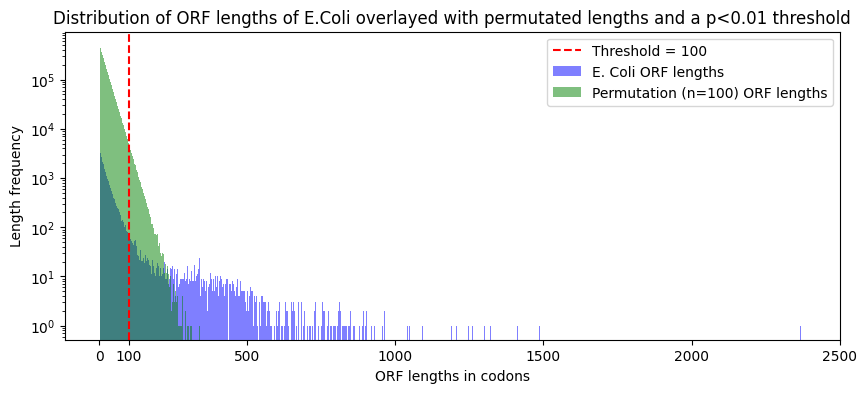

In [15]:

fig1, ax1 = plt.subplots(figsize=(10, 4))
plt.bar(count01.keys(), count01.values(), log=True, width=1, color='blue', alpha=0.5)
plt.bar(count02.keys(), count02.values(), log=True, width=1, color='green', alpha=0.5)
plt.axvline(bacteria_threshold, linestyle='--', color='red')
plt.legend(["Threshold = 100", "E. Coli ORF lengths", "Permutation (n=100) ORF lengths"])
plt.xlabel("ORF lengths in codons")
plt.ylabel("Length frequency")
plt.xticks([0, bacteria_threshold, 500, 1000, 1500, 2000, 2500])
plt.title("Distribution of ORF lengths of E.Coli overlayed with permutated lengths and a p<0.01 threshold")
plt.show()



Is this a good threshold? As we said in the beginning, _E. coli_ is a well-studied organism, so we can easily evaluate our filtering proceedure with the ground truth. We can use many metrics to evaluate our accuracy, but here, we will focus on three: precision, recall, and the F1 score. Please consult Wikipedia if you aren't familiar with these metrics. To calculate each metric, we first have to apply our chosen threshold to our found ORFs, removing ORFs that are too short. Using the ground truth ORFs, we can then identify true positives, false positives, true negatives, and false negatives.

**TASK:**

**b)** Could a different threshold give better precision/recall/F1 scores? We can check! Generate a list of possible thresholds and compute precision/recall/F1 scores for each threshold. Plot all three metrics into a single figure. Clearly show the permutation test threshold. Is the threshold determined by the permutation test reasonable? Could we determine a better threshold? Clearly indicate the permutation threshold and your suggested threshold in the plot. Save the resulting figure to `problem2-proc.png`. Write down your observations and explain your threshold selection into the `bacteria_comments` variable (max. three sentences).

**[5 points]**

The true ORFs can be extracted from the Biopython record object using the provided `extract_gt_orfs` function in `helper_functions.py`.

In [16]:
from helper_functions import extract_gt_orfs

print("Extracting ORFs from NCBI annotation...")
orfs_gt = extract_gt_orfs(record_ecoli, start_codons, stop_codons, verbose=False)
print(f"{len(orfs_gt)} ground truth ORFs found")

Extracting ORFs from NCBI annotation...


c:\Users\Uporabnik\AppData\Local\Programs\Python\Python312\Lib\site-packages\Bio\SeqFeature.py:1940: BiopythonDeprecationWarning: Alias location.position is deprecated and will be removed in a future release. Use location directly, or int(location). However, that will fail for UnknownPosition, and for OneOfPosition and WithinPosition will give the default rather than left-most value.
  warnings.warn(


3868 ground truth ORFs found


In [17]:
matched = [[1, (stop - start)//3] if (o, start, stop) in orfs_gt else [0, (stop - start)//3] for o, start, stop in all_orfs]
matched = np.array(matched)
matched[:][:]

array([[  1,  22],
       [  1, 821],
       [  0,  28],
       ...,
       [  0,  20],
       [  0,  38],
       [  0, 131]])

In [18]:
true_positive = np.sum(matched[matched[:, 1] >= 100][:, 0])
p = true_positive/len(matched[matched[:, 1] >= 100])
r = true_positive/len(orfs_gt)
f1 = 2/((1/p)+(1/r))
p, r, f1, true_positive

(0.47215336308048256, 0.7386246122026887, 0.5760661356991632, 2857)

In [19]:
precision = []
recall = []
f_score = []
true_positive = 0

for n in range(0, 1654): # max n that still has a true positive, the one with length 2368 is a false positive
    true_positive = np.sum(matched[matched[:, 1] >= n][:, 0])
    
    p = true_positive/len(matched[matched[:, 1] >= n])
    r = true_positive/len(orfs_gt)
    f1 = 2/((1/p)+(1/r))
    precision.append(p)
    recall.append(r)
    f_score.append(f1)

In [20]:
max_val = [p + r + f1 for p, r, f1 in zip(precision, recall, f_score)]
max(max_val), max_val.index(max(max_val))

(1.9079226854177946, 147)

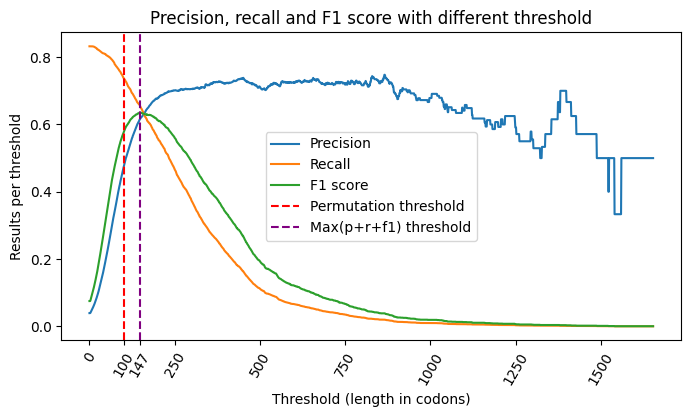

In [21]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(precision)
plt.plot(recall)
plt.plot(f_score)
plt.axvline(bacteria_threshold, linestyle='--', color='red')
plt.axvline(147, linestyle='--', color='purple')
plt.legend(["Precision", "Recall", "F1 score", "Permutation threshold", "Max(p+r+f1) threshold"])
plt.xlabel("Threshold (length in codons)")
plt.ylabel("Results per threshold")
plt.xticks([0, 100, 147, 250, 500, 750, 1000, 1250, 1500], rotation=60)
plt.title("Precision, recall and F1 score with different threshold")
plt.show()

In [22]:
bacteria_comments = """
Does the permutation test threshold make sense?
Yes, by looking only at the ORFs longer than the threshold we focuse on the ORFs that are the more likely 
to be potential gene candidates. Those that often appear through random permutation are likely to be there randomly.
Is there a better threshold we might use?
Yes, as shown on the above graph we can maximise our accuracy (max(p+r+f1)) with a threshold of 147 which represents a percentile 
of 99.89 (p<0.011). These results are obviously based on ground truths which we don't have for SARS-CoV-2.
Can we apply this to the SARS-CoV-2 genome?
Yes, while not the best, 99th percentile permutations threshold is a reasonable way to reduce the amount of potential 
gene candidates.
"""

# SARS-CoV-2

SARS-CoV-2 is the prolific virus that causes the COVID-19 disease. We am sure most of you are well aware of what the disease does, so we'll skip any long-winded introduction. Instead, we'll jump straight into the genome of this pesky little virus.

![](https://www.klinika-golnik.si/storage/_sites/golnik/app/media/Novice/cov-19.jpg)

## Problem 3: SARS-CoV-2 gene candidates

Having convinced ourselves sufficiently that our gene-candidate-finding procedure produces reasonable results, we can now turn our attention to the SARS-CoV-2 genome, which can be found in `data/sars_cov_2.txt`. Remember, we have no ground truth annotations about SARS-CoV-2 from NCBI, so it's up to you to find potential gene candidates and try to determine what each gene does.

**TASK:**
Run your ORF finder on the SARS-CoV-2 genome. Again, using a permutation test with 100 repetitions, determine a threshold for ORF lengths such that we keep only sequences with $p < 0.01$. Plot the distribution of ORF lengths in the random sequences and overlay this with your ORF lengths. Clearly show the permutation test threshold. Save your plot to `problem3.png`. Save your threshold into the `covid_threshold` variable.

**[5 points]**

In [23]:
start_codons = ["ATG"]
stop_codons = ["TGA", "TAA", "TAG"]

In [24]:
file_n = "data/sars_cov_2.txt"
with open(file_n, 'r') as file:
    file_str = file.read()

seq_covid = Seq(file_str)

In [25]:
all_orfs_covid = find_all_orfs(seq_covid, start_codons, stop_codons)
len(all_orfs_covid)

711

In [26]:
cov_lengths01 = [(stop - start)//3 for _, start, stop in all_orfs_covid]
cov_lengths02 = []
for n in range(100):
    tmp = list(seq_covid)
    np.random.shuffle(tmp)
    tmp = Seq(''.join(tmp))
    cov_lengths02 += [(stop - start)//3 for _, start, stop in find_all_orfs(tmp, start_codons, stop_codons)]

In [27]:
cov_count01 = Counter(cov_lengths01)
cov_count02 = Counter(cov_lengths02)

In [28]:
covid_threshold = np.percentile(np.array(cov_lengths02), 99)
covid_threshold

69.0

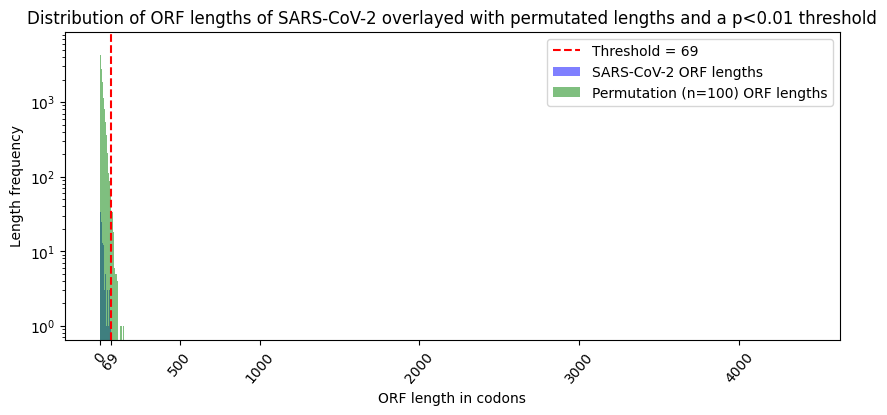

In [29]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.bar(cov_count01.keys(), cov_count01.values(), log=True, width=1, color='blue', alpha=0.5)
plt.bar(cov_count02.keys(), cov_count02.values(), log=True, width=1, color='green', alpha=0.5)
plt.axvline(covid_threshold, linestyle='--', color='red')
plt.legend(["Threshold = 69", "SARS-CoV-2 ORF lengths", "Permutation (n=100) ORF lengths"])
plt.xlabel("ORF length in codons")
plt.ylabel("Length frequency")
plt.xticks([0, covid_threshold, 500, 1000, 2000, 3000, 4000], rotation=50)
plt.title("Distribution of ORF lengths of SARS-CoV-2 overlayed with permutated lengths and a p<0.01 threshold")
plt.show()


## Problem 4: Determining gene functionality from amino acid sequence

Okay, so we've found and filtered down our gene candidates, but now what? The next step is to figure out what these genes might do. So, what _do_ these genes do? Well, nothing by themselves. If DNA is the cookbook, then the genes are the recipes. They tell us how to prepare each dish. Recipes by themselves are nothing but information. It is the actual dishes we care about: the proteins. It is the proteins that actually _do_ things inside our cells.

An organism can read codons in ORFs (hence open-READING-frame) and translate the language of codons into amino acids. Codons in a DNA sequence are translated into amino acids consecutively, forming a long chain. The amino acid chain folds into a macromolecule called protein (as shown in the picture below). Their 3D structure is crucial for their function.
We can predict protein characteristics from the amino acid sequence, such as their location in a cell. However, for a more concrete prediction of the functionality, we would have to use more sophisticated approaches, such as BLAST or AlphaFold.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a9/Protein_folding.png/360px-Protein_folding.png)

**Intro to hydrophobicity**

The hydrophobicity of an amino acid is its tendency to repel water molecules. These amino acids tend to stick together in a non-polar environment. One well-known example of hydrophobicity is the lipid membrane of cells. This hydrophobic cell membrane ensures that the environment outside the cell (water and anything inside that water) stays outside, and all the important bits of the cell (e.g., the mitochondria, nucleus, ribosomes) stay inside the cell.

![](https://i.pinimg.com/originals/5f/44/ac/5f44ac7665a7c003342dca018ce23077.jpg)

Hydrophilic proteins cannot pass through the hydrophobic membrane since its hydrophobic interior will repel them, but hydrophobic proteins can sit happily embedded inside the membrane. These hydrophobic proteins are called _transmembrane_ proteins. Transmembrane proteins typically function as transport channels between the interior and exterior of the cell and enable cell signaling and absorption. In the case of viruses, e.g., SARS-CoV-2, we expect at least some proteins to be embedded in the viral membrane. For instance, SARS-CoV-2 viruses can only enter human cells when the spike protein that sticks out on the exterior of the virus binds to a specific receptor in human cells.

![](https://o.quizlet.com/qBs-A5bu4m1ZI4IdWv1OUA_b.png)

Transmembrane proteins usually contain more hydrophobic amino acids than other proteins because their environment is a strictly hydrophobic lipid membrane. Therefore, one naive approach to finding transmembrane proteins might be to look for proteins with a high degree of hydrophobicity.


The less-biological explanation of all this might be that the little, yellow hydrophobic tails of the lipids in the membrane attract each other because they are all hydrophobic. They can also attract proteins, provided that the amino acids inside that protein are also hydrophobic. The little hydrophobic tails also repel anything hydrophilic, so hydrophilic proteins can't pass through the hydrophobic membrane. So, simply put, hydrophobic molecules attract other hydrophobic molecules and repel any hydrophilic molecules. Finally, hydrophobic molecules repel water, while hydrophilic molecules are drawn toward water.

**TASK**:

**a)** Implement the `translate_to_protein` function in `helper_functions.py`. Do not use Biopython for this in this homework -- we want you to implement this yourself. Stop codons should translate into an empty string ("").

**[5 points]**

**b)** Translate the ground truth ORFs from _E. coli_ and calculate the average hydrophobicity of these proteins. Use the function `extract_gt_orfs` from `helper_functions.py` with parameter `validate=False` to extract all available genes. For each protein, calculate the average protein hydrophobicity. The average protein hydrophobicity is calculated as the average hydrophobicity of all amino acids in the protein sequence. You can find the hydrophobicity values for each amino acid in `data/aa_hydrophobicity.csv`.

Similarly, find, filter, and translate the ORFs (found with your ORF finder and filtered according to the permutation test threshold) in the SARS-CoV-2 genome and calculate the average hydrophobicity of these proteins.

Plot the distribution of the average hydrophobicities for all _E. coli_ proteins. Overlay the histogram with a scatter plot of the hydrophobicity values of your protein candidates found in the SARS-CoV-2 genome. Save the resulting figure to `problem4.png`.

Inspect the distribution of the bacterial proteins. Are there proteins that seem to have a larger hydrophobicity than others? If so, these would probably be good candidates for transmembrane proteins. Compare these to the hydrophobicities of the SARS-CoV-2 proteins. Are there any proteins in the SARS-CoV-2 genome that we could classify as transmembrane proteins just by referencing the distribution of bacterial proteins? If so, save the ORFs you think may correspond to transmembrane proteins to the `transmembrane_candidates` variable. Explain your reasoning in the `transmembrane_comments` variable.

**[10 points]**

In [30]:
from helper_functions import translate_to_protein

In [31]:

all_orfs_gt = extract_gt_orfs(record_ecoli, start_codons, stop_codons, verbose=False, validate_cds=False)
all_orfs_gt[:5], len(all_orfs_gt)

([(1, 189, 255),
  (1, 336, 2799),
  (1, 2800, 3733),
  (1, 3733, 5020),
  (1, 5233, 5530)],
 4298)

In [32]:
import csv
import pandas as pd

hydro_dict = dict()

with open('data/aa_hydrophobicity.csv') as f:
    for line in csv.DictReader(f):
        hydro_dict[line['AA']] = float(line['hydrophobicity'])

In [33]:
def calc_hydro(amino_seq, hydro_dict):
    hydro = 0
    for s in amino_seq:
        hydro += hydro_dict[s]
    return hydro/len(amino_seq)

In [34]:
tmpp = [(o, start, stop, str(seq[start:stop])) if o == 1 else (o, start, stop, str(seq[start:stop].reverse_complement())) for o, start, stop in all_orfs_gt]
tmpp = [(o, start, stop, seq, translate_to_protein(seq)) for o, start, stop, seq in tmpp]
tmpp = [(o, start, stop, seq, amino, calc_hydro(amino, hydro_dict)) for o, start, stop, seq, amino in tmpp]
data = pd.DataFrame(tmpp, columns=["o", "start", "stop", "seq", "amino", "hydro"])
data["hydro"][:5]

0    0.134762
1    0.081707
2    0.101323
3    0.080607
4   -0.094694
Name: hydro, dtype: float64

In [35]:
tmpp = [(o, start, stop, str(seq_covid[start:stop])) if o == 1 else (o, start, stop, str(seq_covid[start:stop].reverse_complement())) for o, start, stop in all_orfs_covid]
tmpp = [(o, start, stop, seq, translate_to_protein(seq)) for o, start, stop, seq in tmpp]
tmpp = [(o, start, stop, seq, amino, calc_hydro(amino, hydro_dict)) for o, start, stop, seq, amino in tmpp]
data_cov = pd.DataFrame(tmpp, columns=["o", "start", "stop", "seq", "amino", "hydro"])
data_cov["length"] = (data_cov["stop"] - data_cov["start"])//3
a = len(data_cov[data_cov["length"]>=covid_threshold])

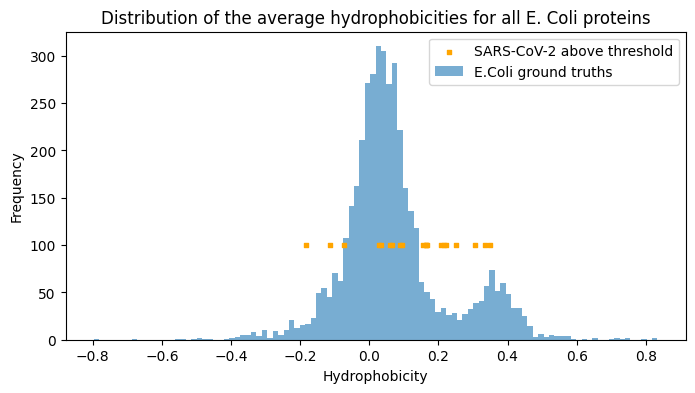

In [36]:
fix, ax = plt.subplots(figsize=(8, 4))
plt.hist(data["hydro"], bins='auto', alpha=0.6)
plt.scatter(data_cov[data_cov["length"]>=covid_threshold]["hydro"], [100 for _ in range(a)], color='orange', marker=',', s=5)
plt.xlabel("Hydrophobicity")
plt.ylabel("Frequency")
plt.legend(["SARS-CoV-2 above threshold", "E.Coli ground truths"])
plt.title("Distribution of the average hydrophobicities for all E. Coli proteins")
plt.show()

In [37]:
transmembrane_candidates = [
    (1, 26244, 26472),
    (1, 15460, 15667),
    (1, 21935, 22199)
]
candidates = data_cov[data_cov["length"]>=covid_threshold]
candidates = candidates[candidates["hydro"]>0.25]
candidates[["o", "start", "stop", "amino", "hydro"]]

,o,start,stop,amino,hydro
32,1,26244,26472,MYSFVSEETGTLIVNSVLLFLAFVVFLLVTLAILTALRLCAYCCNI...,0.349467
221,1,15460,15667,MLNQVEPHQEMPQLLMLIVFLTFVKLSRPMLMHFYLLMVTKLPISM...,0.306765
543,1,21935,22199,MLLLKSVNFNFVMIHFWVFITTKTTKVGWKVSSEFILVRIIALLNM...,0.335632


In [38]:
transmembrane_comments = """
The histogram show 2 distinct hills around which hydrophobicity is distributed. The first (bigger) one 
gathers in a hydrophobicity range of -0.2 to 0.2, while the other (smaller) one gathers in a range 
of 0.25 to 0.5. We are looking for transmembrane proteins which have higher (positive) hydrophobicity,
which mean they need to fall in the range of the smaller hill. We set the hydrophobicity threshold
>= 0.25, which results in 3 transmembrane candidates noted above.
"""

## Bonus problem: Visualizing ORF candidates

You may have noticed in problem 2 that even when keeping all the genes, our recall was well below 1. This means that even without any filtering, we weren't able to find all the ORFs that are actually genes. The reason for this is that we defined ORFs to be the longest contiguous sequence of codons between a start and a stop codon. This is a simplification of what really happens in biology. Not all start codons actually determine the beginning of a coding (gene) sequence. ORFs themselves can contain start codons since the ATG codon itself codes for Methionine. To be completely thorough, each start codon should start its own ORF.

In this exercise, we will define an ORF to be **any** contiguous sequence of codons between a start and a stop codon. For instance, ATGAAAATGAAATGA now contains two ORFs: ATGAAAATGAAATGA and ATGAAATGA.

**TASK**: Implement the `find_all_orfs_nested` function in `helper_functions.py`, following the above definition of an ORF. Visualize where on the genome the ORF candidates are found. Save your plot to `problem-orf-viz.png`.

You can look at this image for a general direction: https://www.ncbi.nlm.nih.gov/nuccore/NC_002549.1?report=graph. You don't need to worry about optimizing the layout -- putting each ORF candidate in its own row is fine. Kudos if you do optimize the layout, though :) If you have a different idea for the visualization, that's even better. Feel free to apply any kind of filtering to the ORFs in your plot.

 **[5 points]**

In [39]:
from helper_functions import find_all_orfs_nested, find_orfs_nested

In [40]:
res = find_all_orfs_nested(seq_covid, start_codons, stop_codons)
norm = [(start, stop) for o, start, stop in res if o == 1]
comp = [(start, stop) for o, start, stop in res if o == -1]
norm = sorted(norm, key=lambda x: x[1]-x[0])[::-1]
comp = sorted(comp, key=lambda x: x[0]-x[1])
res[:5], len(res)

([(1, 900, 933),
  (1, 1071, 1131),
  (1, 1197, 1236),
  (1, 1254, 1278),
  (1, 1380, 1407)],
 1208)

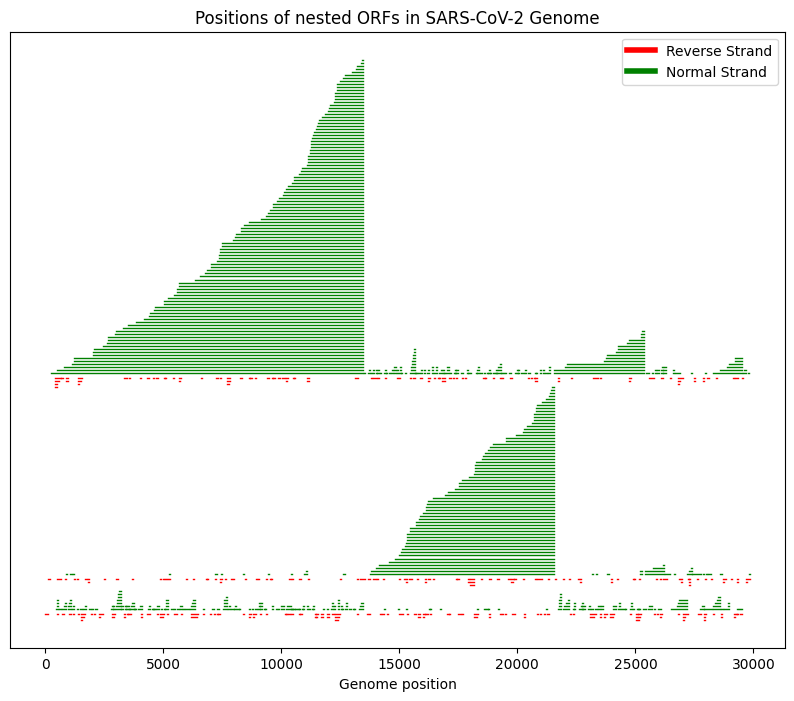

In [41]:
from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], color='red', lw=4), Line2D([0], [0], color='green', lw=4)]

ax, fig = plt.subplots(figsize=(10, 8))
for offset in range(0, 3):
    norm = [(start+offset, stop+offset) for start, stop in find_orfs_nested(seq_covid[offset:], start_codons, stop_codons)]
    norm = sorted(norm, key=lambda x: x[1]-x[0])[::-1]
    
    if offset == 0:
        n = 70
    elif offset == 1:
        n = 470
    else:
        n = 0

    norm_dict = {stop: n for o, _, stop in res if o==1}    
    
    for start, stop in norm:
        normal = plt.plot([start, stop], [norm_dict[stop], norm_dict[stop]], linewidth=1, c='green')
        norm_dict[stop] += 6
        
    ###########--------------------------------------

    comp = [(len(seq_covid)-(stop+offset), len(seq_covid)-(start+offset)) for start, stop in find_orfs_nested(seq_covid.reverse_complement()[offset:], start_codons, stop_codons)]
    comp = sorted(comp, key=lambda x: x[0]-x[1])
    comp_dict = {start: n-10 for o, start, _ in res if o==-1}

    for start, stop in comp:
        reverse = plt.plot([start, stop], [comp_dict[start], comp_dict[start]], linewidth=1, c='red')
        comp_dict[start] -= 6
        
plt.xlabel("Genome position")
plt.legend(custom_lines, ["Reverse Strand", "Normal Strand"], markerscale=3)
plt.yticks([])
plt.title("Positions of nested ORFs in SARS-CoV-2 Genome")
plt.show()

## Bonus problem: How big are viruses?

How does SARS-CoV-2 compare to other viruses? Is it a small virus or a large virus? We can't really say without a reference. Thankfully, NCBI has us covered. NCBI Virus is a subset of NCBI dedicated only to viral sequences. To determine the size of SARS-CoV-2, we'll download a bunch of viral sequences and compare the lengths of their genomes. We could also compare other things, e.g., the number of genes, but it's sufficient to compare the sequence lengths for this homework.

**TASK**: Download all virus genome metadata from [NCBI Virus](https://www.ncbi.nlm.nih.gov/labs/virus/vssi/#/virus). There are between 10,000 to 15,000 of them (you don't need to download the full 10GB of sequence data for this exercise). Create an informative visualization of the distribution of virus sequence lengths. Clearly indicate the length of the SARS-CoV-2 virus.

In a single figure, answer the following questions. Split your figure into three subplots, one for each question:
1. Is SARS-CoV-2 long compared to other human viruses?
2. Is SARS-CoV-2 long compared to other RNA viruses (all variants, all species)?
3. Are RNA bacterial viruses (phages) common?

Copy the question and include a _Yes/No_ answer in the plot using the matplotlib [`text`](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html) function. Save your plot to `problem-virus-size.png`.

Think about the following questions: is the number of DNA vs the number of RNA viruses? Which are more prevalent? Are one kind of virus typically longer than other types of viruses? Where do other viruses fall in this distribution? Some potentially interesting viruses might be SARS and MERS (we heard that SARS-CoV-2 is closely related to those two), ebola, HIV, the common cold, hepatitis a/b/c, ... Save your answers in the `virus_size_comments` variable. Be as brief as possible.

**[5 points]**

In [42]:
import pandas as pd

In [43]:
# human length distribution
# rna length distribution
# rna phages vs everything else
# dna vs rna
vir_lengths = pd.read_csv('sequences.csv')
vir_lengths.head()

,Species,Molecule_type,Length
0,Erwinia phage Fifi44,dsDNA,53559
1,Escherichia phage PO103-1,dsDNA,53040
2,Escherichia phage MLP1,dsDNA,51940
3,Yersinia phage PYps3T,dsDNA,52854
4,Yersinia phage PYps23T,dsDNA,54869


In [44]:

length_RNA = vir_lengths[vir_lengths["Molecule_type"].str.contains('RNA', regex=False)]["Length"]
length_DNA = vir_lengths[vir_lengths["Molecule_type"].str.contains('DNA', regex=False)]["Length"]
# 'ds', 'ss', '' before DNA/RNA, species has phage or human in em
length_human = vir_lengths[(vir_lengths["Species"].str.contains('Human', regex=False)) |
                           (vir_lengths["Species"].str.contains('human', regex=False))]["Length"]
length_phage = vir_lengths[((vir_lengths["Species"].str.contains('phage', regex=False)) |
                            (vir_lengths["Species"].str.contains('Phage', regex=False))) &
                            (vir_lengths["Molecule_type"].str.contains('RNA', regex=False))]


In [45]:
tmppp = vir_lengths[vir_lengths["Molecule_type"].str.contains('RNA', regex=False)]
tmppp[(tmppp["Species"].str.contains('phage', regex=False)) | 
      (tmppp["Species"].str.contains('Phage', regex=False))], print("No RNA phages?")

No RNA phages?


(Empty DataFrame
 Columns: [Species, Molecule_type, Length]
 Index: [],
 None)

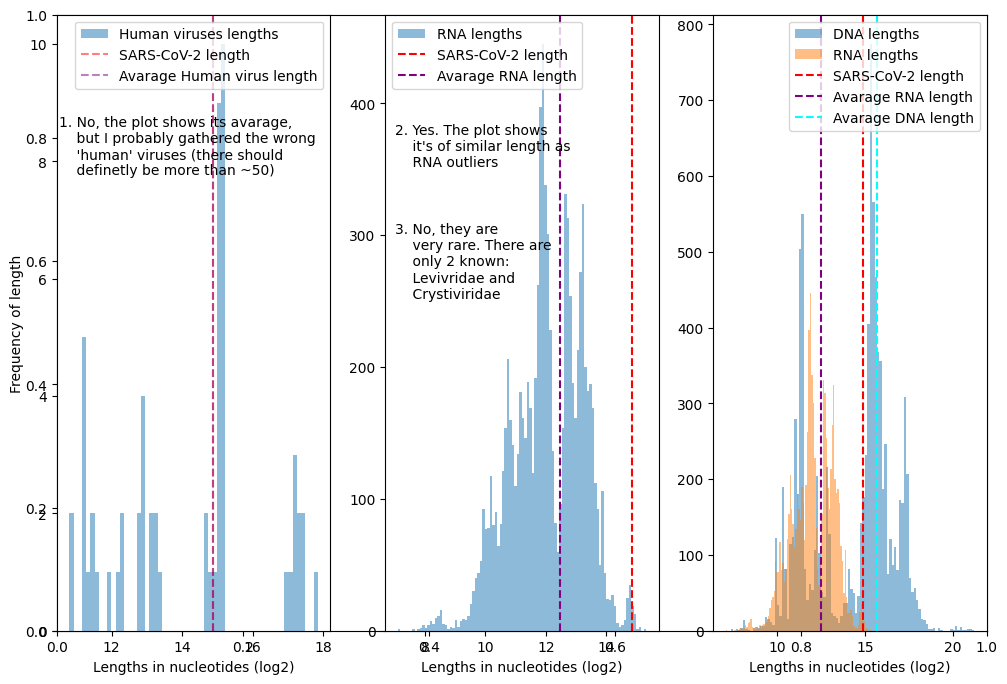

In [46]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.hist(np.log2(length_human), bins=len(length_human), alpha=0.5, label="Human viruses lengths")
plt.axvline(np.log2(len(seq_covid)), linestyle='--', color='red', alpha=0.5, label="SARS-CoV-2 length")
plt.axvline(np.log2(len(seq_covid)), linestyle='--', color='purple', alpha=0.5, label="Avarage Human virus length")
txt = """1. No, the plot shows its avarage,
    but I probably gathered the wrong
    'human' viruses (there should
    definetly be more than ~50)
      """
plt.text(10.5, 7.5, txt)
plt.xlabel("Lengths in nucleotides (log2)")
plt.ylabel("Frequency of length")
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(np.log2(length_RNA), bins=100, alpha=0.5, label="RNA lengths")
plt.axvline(np.log2(len(seq_covid)), linestyle='--', color='red', label="SARS-CoV-2 length")
plt.axvline((np.log2(np.mean(length_RNA))), linestyle='--', color='purple', label="Avarage RNA length")
txt = """2. Yes. The plot shows
    it's of similar length as
    RNA outliers
      """
plt.text(7, 340, txt)
txt = """3. No, they are
    very rare. There are 
    only 2 known: 
    Levivridae and
    Crystiviridae
      """
plt.text(7, 240, txt)
plt.xlabel("Lengths in nucleotides (log2)")
#plt.ylabel("Frequency of length")
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(np.log2(length_DNA), bins=100, alpha=0.5, label="DNA lengths")
plt.hist(np.log2(length_RNA), bins=100, alpha=0.5, label="RNA lengths")
plt.axvline(np.log2(len(seq_covid)), linestyle='--', color='red', label="SARS-CoV-2 length")
plt.axvline(np.log2(np.mean(length_RNA)), linestyle='--', color='purple', label="Avarage RNA length")
plt.axvline(np.log2(np.mean(length_DNA)), linestyle='--', color='cyan', label="Avarage DNA length")

plt.legend()
plt.xlabel("Lengths in nucleotides (log2)")
#plt.ylabel("Frequency of length")

plt.show()


Think about the following questions: is the number of DNA vs the number of RNA viruses? Which are more prevalent? Are one kind of virus typically longer than other types of viruses? Where do other viruses fall in this distribution? Some potentially interesting viruses might be SARS and MERS (we heard that SARS-CoV-2 is closely related to those two), ebola, HIV, the common cold, hepatitis a/b/c, ... Save your answers in the `virus_size_comments` variable. Be as brief as possible.

In [47]:
virus_size_comments = """
1.) The amount of DNA (9392) and RNA (9083) viruses is about the same.
2.) RNA viruses should be more prevalent, but they are more unstable and harder to sequence so 
    we have less data on them.
3.) If by type you meant RNA vs. DNA, then DNA viruses are generally longer (3rd plot on picture)
4.) 5.) I only sampled data by Species, Molecule_type and Length, so I didn't dive into specific types
    and where they stand in the distribution.
"""

In [50]:
bacteria_threshold, bacteria_comments

(100.0,
 "\nDoes the permutation test threshold make sense?\nYes, by looking only at the ORFs longer than the threshold we focuse on the ORFs that are the more likely \nto be potential gene candidates. Those that often appear through random permutation are likely to be there randomly.\nIs there a better threshold we might use?\nYes, as shown on the above graph we can maximise our accuracy (max(p+r+f1)) with a threshold of 147 which represents a percentile \nof 99.89 (p<0.011). These results are obviously based on ground truths which we don't have for SARS-CoV-2.\nCan we apply this to the SARS-CoV-2 genome?\nYes, while not the best, 99th percentile permutations threshold is a reasonable way to reduce the amount of potential \ngene candidates.\n")

In [51]:
covid_threshold

69.0

In [52]:
transmembrane_candidates, transmembrane_comments

([(1, 26244, 26472), (1, 15460, 15667), (1, 21935, 22199)],
 '\nThe histogram show 2 distinct hills around which hydrophobicity is distributed. The first (bigger) one \ngathers in a hydrophobicity range of -0.2 to 0.2, while the other (smaller) one gathers in a range \nof 0.25 to 0.5. We are looking for transmembrane proteins which have higher (positive) hydrophobicity,\nwhich mean they need to fall in the range of the smaller hill. We set the hydrophobicity threshold\n>= 0.25, which results in 3 transmembrane candidates noted above.\n')

In [53]:
virus_size_comments

"\n1.) The amount of DNA (9392) and RNA (9083) viruses is about the same.\n2.) RNA viruses should be more prevalent, but they are more unstable and harder to sequence so \n    we have less data on them.\n3.) If by type you meant RNA vs. DNA, then DNA viruses are generally longer (3rd plot on picture)\n4.) 5.) I only sampled data by Species, Molecule_type and Length, so I didn't dive into specific types\n    and where they stand in the distribution.\n"